#### First, import required libraries

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import subprocess

#### Define number of input samples and other variales

In [62]:
num_samples = 100

# Define fixed control variables (same for all samples)
Xc1_fixed = 0.1
Xc2_fixed = 0.1
Xc3_fixed = 0.1

# additional aleatory variable
omega = 42.0

#### Start adding priors to the model

In [63]:
# Bayesian model
with pm.Model() as bayesian_model:
    # Aleatory variables (normally distributed priors)
    # use truncated normal for Xa1, Xa2 to ensure it is between 0 and 1
    Xa1 = pm.TruncatedNormal("Xa1", mu=0.5, sigma=0.1, shape=num_samples, lower=0, upper=1)  
    Xa2 = pm.TruncatedNormal("Xa2", mu=0.5, sigma=0.1, shape=num_samples, lower=0, upper=1)

    # Epistemic variables (uniform priors for lack of knowledge)
    Xe1 = pm.Uniform("Xe1", lower=0.0, upper=1.0, shape=num_samples)
    Xe2 = pm.Uniform("Xe2", lower=0.0, upper=1.0, shape=num_samples)
    Xe3 = pm.Uniform("Xe3", lower=0.0, upper=1.0, shape=num_samples)

    # Sample from the priors
    prior_samples = pm.sample_prior_predictive(samples=num_samples)  # Generate prior samples

# Print available keys to verify correct names
print("Available keys in prior_samples:", prior_samples.groups())

Sampling: [Xa1, Xa2, Xe1, Xe2, Xe3]


Available keys in prior_samples: ['prior']


#### Save generated samples to input file and plot

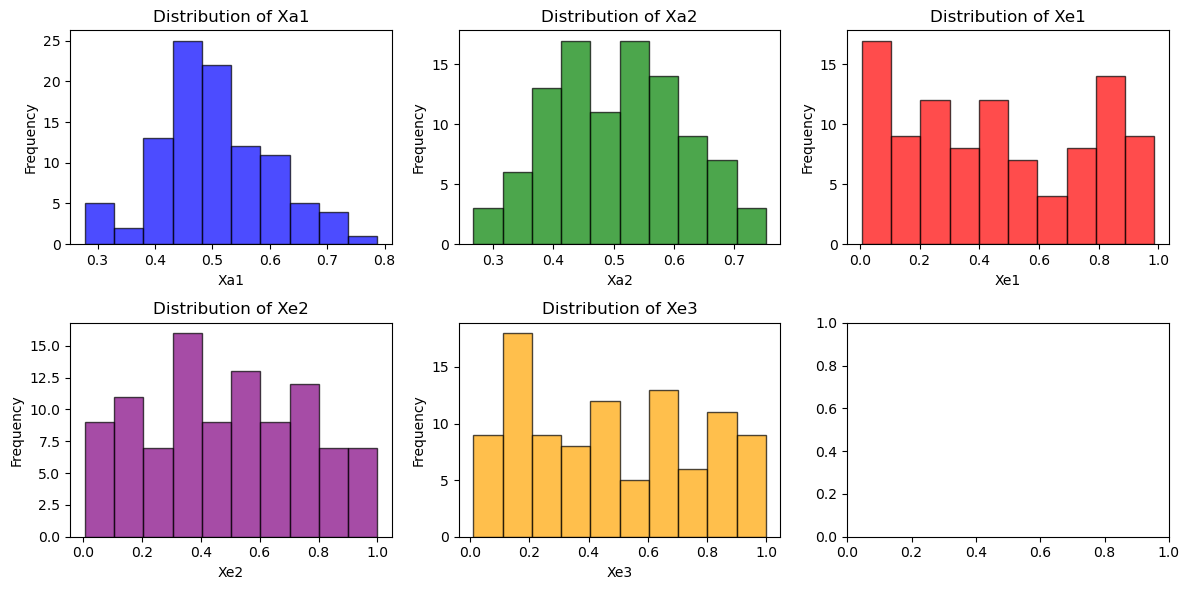

Generated 100 input sets from the Bayesian model and saved them to 'input.txt'.


In [64]:
# Extract samples from the prior group (Ensure correct indexing for 3D array)
Xa1_samples = prior_samples["prior"]["Xa1"].values.reshape(-1, num_samples)[0, :]
Xa2_samples = prior_samples["prior"]["Xa2"].values.reshape(-1, num_samples)[0, :]
Xe1_samples = prior_samples["prior"]["Xe1"].values.reshape(-1, num_samples)[0, :]
Xe2_samples = prior_samples["prior"]["Xe2"].values.reshape(-1, num_samples)[0, :]
Xe3_samples = prior_samples["prior"]["Xe3"].values.reshape(-1, num_samples)[0, :]

# Create arrays for fixed control variables and constant
Xc1_samples = np.full((num_samples, 1), Xc1_fixed)
Xc2_samples = np.full((num_samples, 1), Xc2_fixed)
Xc3_samples = np.full((num_samples, 1), Xc3_fixed)
constant_samples = np.full((num_samples, 1), omega)

# Combine all columns into a single dataset
input_data = np.column_stack([
    Xa1_samples, Xa2_samples, Xe1_samples, Xe2_samples, Xe3_samples,  # Uncertain inputs
    Xc1_samples, Xc2_samples, Xc3_samples,  # Fixed control variables
    constant_samples  # Constant value
])  # Shape: (10, 9)


# Save the generated input values to a text file (for use in local model)
np.savetxt("input3.txt", input_data, delimiter=",", fmt="%.18e")

# Plot histograms for each input variable
fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # Arrange in a 2x3 grid

variables = ["Xa1", "Xa2", "Xe1", "Xe2", "Xe3"]
samples = [Xa1_samples, Xa2_samples, Xe1_samples, Xe2_samples, Xe3_samples]
colors = ["blue", "green", "red", "purple", "orange"]  # Unique colors for each variable

for i, ax in enumerate(axes.flat):
    if i < len(variables):
        ax.hist(samples[i].ravel(), bins=10, alpha=0.7, color=colors[i], edgecolor="black")
        ax.set_title(f"Distribution of {variables[i]}")
        ax.set_xlabel(variables[i])
        ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print confirmation message
print(f"Generated {num_samples} input sets from the Bayesian model and saved them to 'input.txt'.")


#### Run local model with generated input data

In [70]:
%run run_model.py

Simulation executable has been called.

